In [1]:
!nvidia-smi

Sat Mar 13 10:47:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
isTrain = True
Count = "last"

In [4]:
!gdown --id 1-tbY_MbiJ4iMBdMXxiZji_p8425KbSdU

Downloading...
From: https://drive.google.com/uc?id=1-tbY_MbiJ4iMBdMXxiZji_p8425KbSdU
To: /content/AIFORTHAI-LST20Corpus.tar.gz
13.6MB [00:00, 37.2MB/s]


In [5]:
!tar -xf AIFORTHAI-LST20Corpus.tar.gz

# Import data and dependencies

In [6]:
!pip install python-crfsuite
!pip install sklearn-crfsuite
!pip install tensorflow-addons
!pip install tf2crf

     |████████████████████████████████| 747kB 7.0MB/s 
     |████████████████████████████████| 706kB 4.5MB/s 


In [7]:
import glob
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import sklearn_crfsuite
import pycrfsuite
from sklearn_crfsuite import metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Input, LSTM, Bidirectional, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from tf2crf import CRF, ModelWithCRFLoss

from IPython.display import display

In [8]:
SENTENCE_BREAK = ["", "", "", ""]
def readData(path):
    data = []
    for filename in glob.glob(path):
        tmp = []
        f = open(os.path.join(os.getcwd(), filename), "r")
        for line in f:
            if line.strip() == "":
                data.append(tmp)
                tmp = []
            else:
                tmp.append(line.strip().split("\t")) 
        f.close()
    return data

In [9]:
train_data = readData("LST20_Corpus/train/*.txt")
train_data[0]

[['กกต.', 'NN', 'B_ORG', 'B_CLS'],
 ['โต้', 'VV', 'O', 'I_CLS'],
 ['วุฒิสภา', 'NN', 'B_ORG', 'I_CLS'],
 ['ไม่', 'NG', 'O', 'I_CLS'],
 ['มี', 'VV', 'O', 'I_CLS'],
 ['สิทธิ', 'NN', 'O', 'I_CLS'],
 ['สั่ง', 'VV', 'O', 'I_CLS'],
 ['ทบทวน', 'VV', 'O', 'I_CLS'],
 ['ส.ว.', 'NN', 'B_DES', 'I_CLS'],
 ['ถือ', 'VV', 'O', 'I_CLS'],
 ['หุ้น', 'NN', 'O', 'I_CLS'],
 ['สัมปทาน', 'NN', 'O', 'E_CLS']]

In [10]:
%%time
train_data = readData("LST20_Corpus/train/*.txt")
eval_data = readData("LST20_Corpus/eval/*txt")
test_data = readData("LST20_Corpus/test/*.txt")

CPU times: user 4.81 s, sys: 596 ms, total: 5.41 s
Wall time: 5.41 s


In [11]:
tag_count = dict()
for sentence in train_data:
    for word in sentence:
        if word[2] in tag_count:
            tag_count[word[2]] += 1
        else:
            tag_count[word[2]] = 1

In [12]:
tag_count

{'B': 1797,
 'B_BRN': 479,
 'B_DES': 18597,
 'B_DTM': 15724,
 'B_LOC': 36863,
 'B_MEA': 36156,
 'B_NAME': 14,
 'B_NUM': 15424,
 'B_ORG': 51021,
 'B_PER': 49182,
 'B_TRM': 958,
 'B_TTL': 22111,
 'DDEM': 2,
 'E_BRN': 110,
 'E_DES': 2026,
 'E_DTM': 13239,
 'E_LOC': 17242,
 'E_MEA': 10929,
 'E_NUM': 1190,
 'E_ORG': 24035,
 'E_PER': 20313,
 'E_TRM': 334,
 'E_TTL': 50,
 'I': 2,
 'I_BRN': 115,
 'I_DES': 2664,
 'I_DTM': 34988,
 'I_LOC': 8056,
 'I_MEA': 13718,
 'I_NUM': 1987,
 'I_ORG': 33457,
 'I_PER': 22227,
 'I_TRM': 382,
 'I_TTL': 233,
 'MEA_BI': 1,
 'O': 2259093,
 'OBRN_B': 1,
 'ORG_I': 1,
 'PER_I': 1,
 '__': 4}

# CRF

## Data preparation

In [13]:
def word2features(sent, i):
    word = sent[i]
    nextword = SENTENCE_BREAK if i == len(sent)-1 else sent[i+1]
    lastword = SENTENCE_BREAK if i == 0 else sent[i-1]

    features = {
        'word': word[0],
        'word.isDigit': word[0].isdigit(),
        'word.isSpace': word[0] == "_",
        'word.length': len(word[0]),
        'nextword.isSpace': nextword[0] == "_",
        'lastword.isSpace': lastword[0] == "_",
        'BOS': lastword[0] == "",
        'EOS': nextword[0] == ""
    }
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [word[2] for word in sent]

def sent2tokens(sent):
    return [word[0] for word in sent]

In [14]:
%%time 
x_train = [sent2features(sent) for sent in train_data]
y_train = [sent2labels(sent) for sent in train_data]
x_eval = [sent2features(sent) for sent in eval_data]
y_eval = [sent2labels(sent) for sent in eval_data]
x_test = [sent2features(sent) for sent in test_data]
y_test = [sent2labels(sent) for sent in test_data]

CPU times: user 3.75 s, sys: 458 ms, total: 4.21 s
Wall time: 4.21 s


In [15]:
print(x_train[0][0])
print(y_train[0][0])
print(len(x_train[0]))
print(len(y_train[0]))

{'word': 'กกต.', 'word.isDigit': False, 'word.isSpace': False, 'word.length': 4, 'nextword.isSpace': False, 'lastword.isSpace': False, 'BOS': True, 'EOS': False}
B_ORG
12
12


## Model

In [16]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)
crf.fit(x_train, y_train, x_eval, y_eval)

loading dev data to CRFsuite:   9%|▉         | 523/5620 [00:00<00:00, 5224.69it/s]

loading dev data to CRFsuite: 100%|██████████| 5620/5620 [00:01<00:00, 5430.99it/s]



Holdout group: 2

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 67793
Seconds required: 1.632

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=28.49 loss=4748490.40 active=67547 precision=0.019  recall=0.024  F1=0.021  Acc(item/seq)=0.805 0.136  feature_norm=1.00
Iter 2   time=15.18 loss=4274216.10 active=64557 precision=0.019  recall=0.024  F1=0.021  Acc(item/seq)=0.805 0.136  feature_norm=1.30
Iter 3   time=14.93 loss=3917706.43 active=66377 precision=0.019  recall=0.024  F1=0.021  Acc(item/seq)=0.805 0.136  feature_norm=1.49
Iter 4   time=14.97 loss=2996928.17 active=62179 precision=0.019  recall=0.024  F1=0.021  Acc(item/seq)=0.805 0.136  feature_norm=2.72
Iter 5   time=29.41 loss=2688268.33 activ

## Evaluation

In [17]:
y_pred = crf.predict(x_test)

In [18]:
labels = list(crf.classes_)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


0.934929539964185

In [19]:
labels = list(crf.classes_)
labels.remove('O')

In [20]:
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


0.7470080659858999

In [54]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
report_crf = metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=4
)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---
              precision    recall  f1-score   support

           B     0.6308    0.9375    0.7542       144
           I     0.0000    0.0000    0.0000         0
         ABB     0.0000    0.0000    0.0000         0
      OBRN_B     0.0000    0.0000    0.0000         0
        DDEM     0.0000    0.0000    0.0000         0
      MEA_BI     0.0000    0.0000    0.0000         0
       PER_I     0.0000    0.0000    0.0000         0
       LOC_I     0.0000    0.0000    0.0000         0
       ORG_I     0.0000    0.0000    0.0000         0
          __     0.0000    0.0000    0.0000         0
       B_BRN     0.3684    0.1489    0.2121        47
       E_BRN     0.2500    0.1250    0.1667         8
       I_BRN     0.3333    0.2000    0.2500         5
       B_DES     0.8938    0.7942    0.8411      1176
       E_DES     0.6711    0.5152    0.5829       198
       I_DES     0.7343    0.5147    0.6052       204
       B_DTM     0.8239    0.6900    0.7510      1329
       E_DTM     0.8158

In [68]:
report_crf_data = [line.split() for line in report_crf.split("\n") if len(line.split()) != 0 ]
col = ["tag_name"] + report_crf_data[0] + ["None"]
col[3] = 'f_score'
report_crf_df = pd.DataFrame(report_crf_data[11:], columns=col)
report_crf_df = report_crf_df.drop(report_crf_df.index[report_crf_df["tag_name"] == "B_NAME"]).drop("None", axis=1)

def mul100(row):
    if row != "avg":
        return float(row)*100
    return 0.0

report_crf_df["precision"] = report_crf_df["precision"].apply(lambda row: mul100(row))
report_crf_df["recall"] = report_crf_df["recall"].apply(lambda row: mul100(row))
report_crf_df["f_score"] = report_crf_df["f_score"].apply(lambda row: mul100(row))
report_crf_df

,tag_name,precision,recall,f_score,support
0,B_BRN,36.84,14.89,21.21,47
1,E_BRN,25.00,12.50,16.67,8
2,I_BRN,33.33,20.00,25.00,5
3,B_DES,89.38,79.42,84.11,1176
4,E_DES,67.11,51.52,58.29,198
5,I_DES,73.43,51.47,60.52,204
6,B_DTM,82.39,69.00,75.10,1329
7,E_DTM,81.58,76.19,78.80,1151
8,I_DTM,90.78,83.93,87.22,2969
9,B_LOC,75.31,62.71,68.44,2344


In [71]:
report_crf_df.replace({"micro":"Micro", "macro":"Macro"}, inplace=True)

In [72]:
report_crf_df.to_csv("/content/drive/MyDrive/Lecture/Senior/2/NLP/Midterm/CRF_report.csv")

# Preparation

## Helper function

In [13]:
def reformatData(data):
    new_data = []
    for sentence in data:
        new_sentence = []
        for word in sentence:
            if word[0] == "_":
                new_data.append(new_sentence)
                new_sentence = []
            else:
                new_sentence.append(word)
    return new_data
    
def getWordLabelMap(list_of_datas):
    word2idx = {}
    idx2word = {}
    label2idx = {}
    idx2label = {}
    for data in list_of_datas:
        for sentence in data:
            for word, pos, ner, clsb in sentence:
                if word not in word2idx:
                    word2idx[word] = len(word2idx)
                    idx2word[word2idx[word]] = word
                if ner not in label2idx:
                    label2idx[ner] = len(label2idx)
                    idx2label[label2idx[ner]] = ner
    word2idx['UNK'] = len(word2idx)
    idx2word[word2idx['UNK']] = "UNK"

    return word2idx, idx2word, label2idx, idx2label

def word2features(sent, i, w2i):
    word = sent[i][0]
    if word in w2i :
        return w2i[word]
    else :
        return w2i['UNK']

def sent2features(sent, w2i):
    return np.asarray([word2features(sent, i, w2i) for i in range(len(sent))])

def sent2labels(sent, l2i):
    return np.asarray([l2i[word[2]] for word in sent],dtype='int32')

def oneHotLabel(label_data):
    y_temp =[]
    for i in range(len(label_data)):
        y_temp.append(np.eye(len(label2idx))[label_data[i]][np.newaxis,:])
    y_train = np.asarray(y_temp).reshape(-1,label_data.shape[1],len(label2idx))
    del(y_temp)
    return y_train

In [14]:
def outputToLabel(y, seq_len):
    out = []
    for i in range(len(y)):
        if(i==seq_len):
            break
        out.append(np.argmax(y[i]))
    return out

In [15]:
def evaluation_report(y_true, y_pred, idx2label):
    # retrieve all tags in y_true
    tag_list = list(idx2label.keys())
    # count correct points
    tag_info = dict()
    for tag in tag_list:
        tag_info[tag] = {'correct_tagged': 0, 'y_true': 0, 'y_pred': 0}

    all_correct = 0
    all_count = sum([len(sent) for sent in y_true])
    for sent_true, sent_pred in zip(y_true, y_pred):
        for tag_true, tag_pred in zip(sent_true, sent_pred):
            if tag_true == tag_pred:
                tag_info[tag_true]['correct_tagged'] += 1
                all_correct += 1
            tag_info[tag_true]['y_true'] += 1
            tag_info[tag_pred]['y_pred'] += 1
            
    # summarize and make evaluation result
    correct_sum = 0
    predict_sum = 0
    true_sum = 0
    # Macro = average of that score, micro = sum of all correct/sum of all tag
    tag_count = 0
    precision_sum = 0
    recall_sum = 0

    eval_list = list()
    for tag in tag_list:
        eval_result = dict()
        eval_result['tag'] = tag
        eval_result['tag_name'] = idx2label[tag]
        eval_result['correct_count'] = tag_info[tag]['correct_tagged']
        eval_result['true_count'] = tag_info[tag]['y_true']
        eval_result['predict_count'] = tag_info[tag]['y_pred']
        
        precision = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_pred'])*100 if tag_info[tag]['y_pred'] else '-'
        recall = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_true'])*100 if (tag_info[tag]['y_true']) > 0 else 0
        eval_result['precision'] = precision
        eval_result['recall'] = recall
        eval_result['f_score'] = (2*precision*recall)/(precision+recall) if (type(precision) is float and recall > 0) else '-'
        
        eval_list.append(eval_result)

    accuracy = (all_correct / all_count) * 100

    df = pd.DataFrame.from_dict(eval_list)

    sum_correct_count = sum(df.correct_count)
    sum_true_count = sum(df.true_count)
    sum_predict_count = sum(df.predict_count)

    micro_precision = (sum_correct_count/sum_predict_count)*100
    micro_recall = (sum_correct_count/sum_true_count)*100
    micro_f_score = (2*micro_precision*micro_recall)/(micro_precision+micro_recall)
    eval_list.append({'tag':"MI", 'tag_name':"Micro", 
                      'correct_count':sum_correct_count, 'true_count': sum_true_count, 'predict_count':sum_predict_count, 
                      'precision': micro_precision, 'recall': micro_recall, 'f_score': micro_f_score})

    df_present = df[(df.recall != "-") & (df.precision != "-")]
    macro_precision = sum(df_present.precision)/len(df_present)
    macro_recall = sum(df_present.recall)/len(df_present)
    macro_f_score = (2*macro_precision*macro_recall)/(macro_precision+macro_recall)

    eval_list.append({'tag':"MA", 'tag_name':"Macro",
                      'correct_count':sum_correct_count, 'true_count':sum_true_count, 'predict_count':sum_predict_count,
                      'precision':macro_precision, 'recall':macro_recall, 'f_score':macro_f_score})
    
    df = pd.DataFrame.from_dict(eval_list)
    df = df[df["tag_name"] != "O"]
    sum_correct_count = sum(df.correct_count)
    sum_true_count = sum(df.true_count)
    sum_predict_count = sum(df.predict_count)

    micro_precision = (sum_correct_count/sum_predict_count)*100
    micro_recall = (sum_correct_count/sum_true_count)*100
    micro_f_score = (2*micro_precision*micro_recall)/(micro_precision+micro_recall)
    eval_list.append({'tag':"MIO", 'tag_name':"MicroWithoutO", 
                      'correct_count':sum_correct_count, 'true_count': sum_true_count, 'predict_count':sum_predict_count, 
                      'precision': micro_precision, 'recall': micro_recall, 'f_score': micro_f_score})

    df_present = df[(df.recall != "-") & (df.precision != "-")]
    macro_precision = sum(df_present.precision)/len(df_present)
    macro_recall = sum(df_present.recall)/len(df_present)
    macro_f_score = (2*macro_precision*macro_recall)/(macro_precision+macro_recall)

    eval_list.append({'tag':"MAO", 'tag_name':"MacroWithoutO",
                      'correct_count':sum_correct_count, 'true_count':sum_true_count, 'predict_count':sum_predict_count,
                      'precision':macro_precision, 'recall':macro_recall, 'f_score':macro_f_score})
    
    eval_list.append({'tag': 'Accuracy','tag_name':accuracy, 'correct_count': '', 'precision': '', 'recall': '', 'f_score': ''})

    df = pd.DataFrame.from_dict(eval_list)
    df = df[['tag','tag_name', 'precision', 'recall', 'f_score', 'correct_count', 'true_count', 'predict_count']]
    display(df)
    return df

## Data preparation

In [16]:
word2idx, idx2word, label2idx, idx2label = getWordLabelMap([train_data, eval_data, test_data])

In [17]:
train_data_nn = reformatData(train_data)
eval_data_nn = reformatData(eval_data)
test_data_nn = reformatData(test_data)

In [18]:
%%time
x_train = [sent2features(sent, word2idx) for sent in train_data_nn]
y_train = [sent2labels(sent, label2idx) for sent in train_data_nn]
x_eval = [sent2features(sent, word2idx) for sent in eval_data_nn]
y_eval = [sent2labels(sent, label2idx) for sent in eval_data_nn]
x_test = [sent2features(sent, word2idx) for sent in test_data_nn]
y_test = [sent2labels(sent, label2idx) for sent in test_data_nn]

CPU times: user 3.4 s, sys: 57.8 ms, total: 3.46 s
Wall time: 3.46 s


In [19]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=None, padding='post', truncating='pre', value=0)
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=None, padding='post', truncating='pre', value=0)
x_eval = tf.keras.preprocessing.sequence.pad_sequences(x_eval, maxlen=147, padding='post', truncating='pre', value=0)
y_eval = tf.keras.preprocessing.sequence.pad_sequences(y_eval, maxlen=147, padding='post', truncating='pre', value=0)
y_eval = oneHotLabel(y_eval)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=147, padding='post', truncating='pre', value=0)

# LSTM

## Model

In [ ]:
def getLSTM(input_dim, output_dim, input_length, n_tags):
    input = Input(shape=(input_length,))
    output = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, mask_zero=True)(input)
    output = LSTM(units=output_dim, return_sequences=True)(output)
    output = TimeDistributed(Dense(n_tags, activation='softmax'))(output)

    model = Model(input, output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()
    return model
    
mLSTM = getLSTM(input_dim=len(word2idx) , output_dim= 64, input_length=x_train.shape[1] , n_tags=len(label2idx))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 147)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 147, 64)           3505344   
_________________________________________________________________
lstm (LSTM)                  (None, 147, 64)           33024     
_________________________________________________________________
time_distributed (TimeDistri (None, 147, 42)           2730      
Total params: 3,541,098
Trainable params: 3,541,098
Non-trainable params: 0
_________________________________________________________________


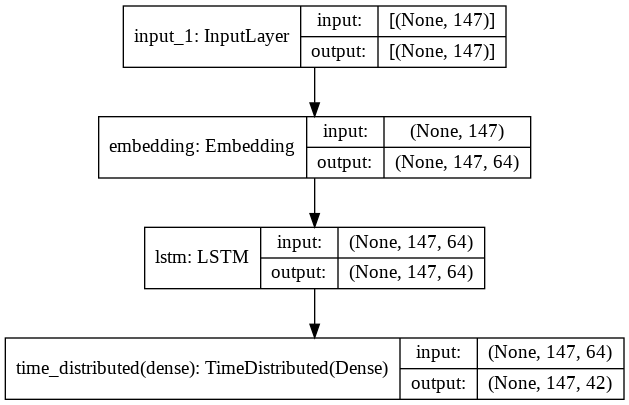

In [ ]:
plot_model(mLSTM, to_file="/content/drive/MyDrive/Lecture/Senior/2/NLP/Midterm/LSTM_model.png", show_shapes=True, show_layer_names=True)

In [ ]:
%%time
if isTrain:
    epochs = 15
    batch_size = 1024
    for c in range(epochs):
        print("epochs:", c)
        prev_i = 0
        for i in range(1, x_train.shape[0]//batch_size+2):
            x = x_train[ prev_i*batch_size : i*batch_size ]
            y = oneHotLabel(y_train[ prev_i*batch_size : i*batch_size ])
            loss = mLSTM.train_on_batch(x, y)
            prev_i = i
            del(y)
        print(loss)
        mLSTM.evaluate(x_eval, y_eval, batch_size)
    # mLSTM.save("/content/drive/MyDrive/Lecture/Senior/2/NLP/weights/LSTM_{}_{}".format(Count, epochs))

epochs: 0
[0.017842717468738556, 0.8039272427558899]
39/39 [==============================] - 3s 36ms/step - loss: 0.0240 - categorical_accuracy: 0.7810
epochs: 1
[0.013154424726963043, 0.8634132146835327]
39/39 [==============================] - 1s 36ms/step - loss: 0.0169 - categorical_accuracy: 0.8356
epochs: 2
[0.0096403444185853, 0.9208778738975525]
39/39 [==============================] - 1s 35ms/step - loss: 0.0120 - categorical_accuracy: 0.8828
epochs: 3
[0.006963213440030813, 0.9315622448921204]
39/39 [==============================] - 1s 35ms/step - loss: 0.0102 - categorical_accuracy: 0.8943
epochs: 4
[0.005306081846356392, 0.9382038712501526]
39/39 [==============================] - 1s 35ms/step - loss: 0.0095 - categorical_accuracy: 0.8999
epochs: 5
[0.0046494933776557446, 0.9431129097938538]
39/39 [==============================] - 1s 35ms/step - loss: 0.0091 - categorical_accuracy: 0.9022
epochs: 6
[0.004340667277574539, 0.9454230666160583]
39/39 [=======================

## Evaluation

In [ ]:
%%time
y_pred = mLSTM.predict(x_test)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
report_LSTM = evaluation_report(y_test, ypred, idx2label)

,tag,tag_name,precision,recall,f_score,correct_count,true_count,predict_count
0,0,B_ORG,75.1758,59.7541,66.5836,2138,3578.0,2844.0
1,1,O,96.4002,97.3637,96.8796,107732,110649.0,111755.0
2,2,B_DES,81.3769,83.8182,82.5795,922,1100.0,1133.0
3,3,B_PER,86.7647,85.3921,86.0729,2537,2971.0,2924.0
4,4,B_LOC,68.4869,64.0766,66.2084,1204,1879.0,1758.0
5,5,I_LOC,41,31.1787,35.4212,82,263.0,200.0
6,6,E_LOC,65.7556,58.596,61.9697,409,698.0,622.0
7,7,B_TTL,90.3943,95.2417,92.7547,1261,1324.0,1395.0
8,8,I_PER,23.0769,13.9535,17.3913,6,43.0,26.0
9,9,E_PER,53.8586,88.6893,67.0186,1333,1503.0,2475.0


CPU times: user 6.37 s, sys: 2.87 s, total: 9.23 s
Wall time: 8.05 s


In [ ]:
report_LSTM.to_csv("/content/drive/MyDrive/Lecture/Senior/2/NLP/Midterm/LSTM_report.csv")

# Bi-LSTM

## Model

In [ ]:
def getBiLSTM(input_dim, output_dim, input_length, n_tags):
    input = Input(shape=(input_length,))
    output = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, mask_zero=True)(input)
    output = Bidirectional(LSTM(output_dim, return_sequences=True))(output)
    output = TimeDistributed(Dense(n_tags, activation='softmax'))(output)

    model = Model(input, output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()
    return model
    
biLSTM = getBiLSTM(input_dim=len(word2idx) , output_dim= 64, input_length=x_train.shape[1] , n_tags=len(label2idx))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 147)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 147, 64)           3505344   
_________________________________________________________________
bidirectional (Bidirectional (None, 147, 128)          66048     
_________________________________________________________________
time_distributed (TimeDistri (None, 147, 42)           5418      
Total params: 3,576,810
Trainable params: 3,576,810
Non-trainable params: 0
_________________________________________________________________


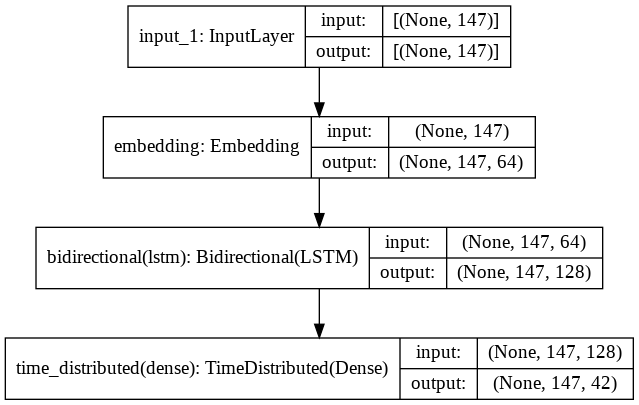

In [ ]:
plot_model(biLSTM, to_file="/content/drive/MyDrive/Lecture/Senior/2/NLP/Midterm/BiLSTM_model.png", show_shapes=True, show_layer_names=True)

In [ ]:
%%time
if isTrain:
    epochs = 15
    batch_size = 1024
    for c in range(epochs):
        print("epochs:", c)
        prev_i = 0
        for i in range(1, x_train.shape[0]//batch_size+2):
            x = x_train[ prev_i*batch_size : i*batch_size ]
            y = oneHotLabel(y_train[ prev_i*batch_size : i*batch_size ])
            loss = biLSTM.train_on_batch(x, y)
            prev_i = i
            del(y)
        print(loss)
        biLSTM.evaluate(x_eval, y_eval, batch_size, verbose=2)
    # biLSTM.save("/content/drive/MyDrive/Lecture/Senior/2/NLP/weights/biLSTM_{}_{}".format(Count, epochs))

epochs: 0
[0.01624753326177597, 0.8149003982543945]
39/39 - 4s - loss: 0.0216 - categorical_accuracy: 0.8026
epochs: 1
[0.010380747728049755, 0.9162575602531433]
39/39 - 2s - loss: 0.0128 - categorical_accuracy: 0.8775
epochs: 2
[0.006936471909284592, 0.9292520880699158]
39/39 - 2s - loss: 0.0097 - categorical_accuracy: 0.9011
epochs: 3
[0.004884492140263319, 0.9460005760192871]
39/39 - 2s - loss: 0.0087 - categorical_accuracy: 0.9093
epochs: 4
[0.004003711044788361, 0.9506208300590515]
39/39 - 2s - loss: 0.0082 - categorical_accuracy: 0.9126
epochs: 5
[0.0035801250487565994, 0.9535084962844849]
39/39 - 2s - loss: 0.0080 - categorical_accuracy: 0.9145
epochs: 6
[0.0033429444301873446, 0.9575512409210205]
39/39 - 2s - loss: 0.0078 - categorical_accuracy: 0.9161
epochs: 7
[0.0031999649945646524, 0.9589951038360596]
39/39 - 2s - loss: 0.0077 - categorical_accuracy: 0.9177
epochs: 8
[0.003111375728622079, 0.9592838287353516]
39/39 - 2s - loss: 0.0077 - categorical_accuracy: 0.9184
epochs: 

## Evaluation

In [ ]:
%%time
y_pred = biLSTM.predict(x_test)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
report_BiLSTM = evaluation_report(y_test, ypred, idx2label)

,tag,tag_name,precision,recall,f_score,correct_count,true_count,predict_count
0,0,B_ORG,78.3949,68.2504,72.9718,2442,3578.0,3115.0
1,1,O,97.1303,97.643,97.386,108041,110649.0,111233.0
2,2,B_DES,84.3172,87,85.6376,957,1100.0,1135.0
3,3,B_PER,89.1715,87.3107,88.2313,2594,2971.0,2909.0
4,4,B_LOC,72.8375,70.3566,71.5755,1322,1879.0,1815.0
5,5,I_LOC,49.0385,38.7833,43.3121,102,263.0,208.0
6,6,E_LOC,66.7665,63.8968,65.3001,446,698.0,668.0
7,7,B_TTL,94.6909,98.3384,96.4802,1302,1324.0,1375.0
8,8,I_PER,29.0323,20.9302,24.3243,9,43.0,31.0
9,9,E_PER,55.4666,92.149,69.25,1385,1503.0,2497.0


CPU times: user 10.9 s, sys: 6.57 s, total: 17.5 s
Wall time: 14 s


In [ ]:
report_BiLSTM.to_csv("/content/drive/MyDrive/Lecture/Senior/2/NLP/Midterm/BiLSTM_report.csv")

# Bi-LSTM with CRF

## Model

In [20]:
def getBiLSTMwithCRF(input_dim, output_dim, input_length, n_tags):
    input = Input(shape=(input_length), dtype='int32')
    output = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, mask_zero=True)(input)
    output = Bidirectional(LSTM(output_dim, return_sequences=True))(output)
    output = TimeDistributed(Dense(n_tags, activation=None))(output)
    crf = CRF(dtype='float32')
    output = crf(output)

    model = Model(input, output)
    model = ModelWithCRFLoss(model)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

biLSTMwithCRF = getBiLSTMwithCRF(input_dim=len(word2idx) , output_dim=64, input_length=x_train.shape[1] , n_tags=len(label2idx))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


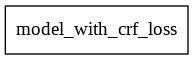

In [21]:
plot_model(biLSTMwithCRF, to_file="/content/drive/MyDrive/Lecture/Senior/2/NLP/Midterm/BiLSTM_CRF_model.png", show_shapes=True, show_layer_names=True)

In [22]:
%%time
if isTrain:
    epochs = 10
    batch_size = 1024
    for c in range(epochs):
        print("epochs:", c)
        prev_i = 0
        for i in range(1, x_train.shape[0]//batch_size+2):
            x = x_train[ prev_i*batch_size : i*batch_size ]
            y = oneHotLabel(y_train[ prev_i*batch_size : i*batch_size ])
            loss = biLSTMwithCRF.train_on_batch(x, y.argmax(axis=2))
            prev_i = i
            del(y)
        print(loss)
        biLSTMwithCRF.evaluate(x_eval, y_eval.argmax(axis=2), batch_size, verbose=2)
    # biLSTMwithCRF.save("/content/drive/MyDrive/Lecture/Senior/2/NLP/weights/biLSTMwithCRF_{}_{}".format(Count, epochs))

epochs: 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


[0.8166329860687256, 0.8166329860687256]
39/39 - 10s - crf_loss_val: 2.3756 - val_accuracy: 0.8092
epochs: 1
[0.913081169128418, 0.913081169128418]
39/39 - 7s - crf_loss_val: 1.3839 - val_accuracy: 0.8852
epochs: 2
[0.9434016942977905, 0.9434016942977905]
39/39 - 7s - crf_loss_val: 1.0177 - val_accuracy: 0.9060
epochs: 3
[0.9488882422447205, 0.9488882422447205]
39/39 - 7s - crf_loss_val: 0.8922 - val_accuracy: 0.9107
epochs: 4
[0.9488882422447205, 0.9488882422447205]
39/39 - 7s - crf_loss_val: 0.8462 - val_accuracy: 0.9136
epochs: 5
[0.9529309868812561, 0.9529309868812561]
39/39 - 7s - crf_loss_val: 0.8233 - val_accuracy: 0.9151
epochs: 6
[0.9543747901916504, 0.9543747901916504]
39/39 - 7s - crf_loss_val: 0.8067 - val_accuracy: 0.9160
epochs: 7
[0.9537972807884216, 0.9537972807884216]
39/39 - 7s - crf_loss_val: 0.7949 - val_accuracy: 0.9164
epochs: 8
[0.9465780854225159, 0.9465780854225159]
39/39 - 7s - crf_loss_val: 0.7884 - val_accuracy: 0.9168
epochs: 9
[0.9471556544303894, 0.947155

## Evaluation

In [23]:
%%time
y_pred = biLSTMwithCRF.predict(x_test)
ypred = [outputToLabel(y_pred[1][i],len(y_test[i])) for i in range(len(y_pred[1]))]
report_biLSTMCRF = evaluation_report(y_test, ypred, idx2label)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


,tag,tag_name,precision,recall,f_score,correct_count,true_count,predict_count
0,0,B_ORG,62.3996,67.3002,64.7573,2408,3578.0,3859.0
1,1,O,96.5746,97.3845,96.9779,107755,110649.0,111577.0
2,2,B_DES,80.9959,88.7273,84.6855,976,1100.0,1205.0
3,3,B_PER,82.0858,88.2195,85.0422,2621,2971.0,3193.0
4,4,B_LOC,67.5876,72.9111,70.1485,1370,1879.0,2027.0
5,5,I_LOC,38.0282,30.7985,34.0336,81,263.0,213.0
6,6,E_LOC,56.8063,62.1777,59.3707,434,698.0,764.0
7,7,B_TTL,95.1435,97.6586,96.3846,1293,1324.0,1359.0
8,8,I_PER,19.1489,20.9302,20,9,43.0,47.0
9,9,E_PER,75.0506,74.0519,74.5479,1113,1503.0,1483.0


CPU times: user 2min 10s, sys: 24.3 s, total: 2min 34s
Wall time: 1min 29s


In [24]:
report_biLSTMCRF.to_csv("/content/drive/MyDrive/Lecture/Senior/2/NLP/Midterm/BiLSTMCRF_report2.csv")